In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.special import gamma, binom
from scipy.sparse import diags, kron, block_diag
from scipy.sparse.linalg import spsolve, eigs
from scipy.optimize import fsolve
from scipy.linalg import lstsq
from pathlib import Path
import time
import json
from tqdm import tqdm

import datetime


def compute_classical_energy(u, N, eps, h):
    """Compute the discrete energy :

    Parameters
    ----------
    u : 2D-array
        The numerical solution of u.
    eps : float
        The diffusion coefficient.
    h : float
        The mesh size of x and y direction.
    N : tuple
        The number of grids.

    Returns
    -------
    float
        The discrete energy of u.
        
    """
    if len(N) == 1:
        ux = np.gradient(u)/h
        term1 = np.sum((eps**2 / 2.0) * (ux**2))
        term2 = np.sum(((1 - u ** 2) ** 2) / 4)
    
    elif len(N) == 2:
        u = np.reshape(u, N)
        ux = np.gradient(u, axis = 1)/h
        uy = np.gradient(u, axis = 0)/h
        term1 = np.sum((eps**2 / 2.0) * (ux**2 + uy**2))
        term2 = np.sum(((1 - u ** 2) ** 2) / 4)
    
    return h * (term1 + term2)

def set_coef(terminate_point, alpha, method='L1'):
    """Set the coefficient of fractional scheme:

    Parameters
    ----------
    terminate_point : int
        The number of coefficient.
    alpha : float
        The fractional order between (0,1).
    method : str 
        The coefficient of scheme to generate.
        (defualt is 'L1')
        possible options : 'L1', 'GL'.

    Returns
    -------
    1D array
        The coefficient array generated 
        based on the selected method.
        
    """
    
    if method == 'L1':
        coef = [(j)**(1-alpha) - (j-1)**(1-alpha) \
                for j in range(1, terminate_point+1)]
    elif method == 'GL':
        coef = [(-1)**(j) * binom(alpha, j) \
                for j in range(0, terminate_point+1)]
        
    return np.array(coef)

def set_Laplacian2D(Nx, h, BC='periodic'):
    """Set the 2D discrete laplacian by central difference:
        Neumann boundary laplacian is discreted by 
        
        x-direction : u_{-1,j,k}=u_{0,j,k} and
                      u_{Nx+1,j,k}=u_{0,j,k}
                          
        y-direction : u_{i,-1,k}=u_{i,0,k} and
                      u_{i,Nx+1,k}=u_{i,0,k}
            
        Built by two block matries and two off-diagnoals, 
        corner block (corB), central block (cenB)
            
        The diagonal block is [corB, cenB, ..., cenB, corB]
        The off-diagnoals are diagonals line below (above) 
        the main diagonal by Nx positions, all consisting of 1.
            
        L = diagonal block + off-diagonals

    Parameters
    ----------
    Nx : int
        The number of mesh grids.
    h : float
        The mesh size.
    BC : str
        The boundary condition. (default is 'periodic')
        possible options : 'periodic', 'nuemann'

    Returns
    -------
    2D array
        The discrete laplacian with certain boundary.
        
    """
    if BC == 'periodic':
        diag = np.ones(Nx)
        L = diags([diag, -2*diag, diag, 1, 1], \
                  [-1, 0, 1 , -Nx+1, Nx-1], shape=(Nx, Nx))
        I = diags(diag, shape=(Nx, Nx))
    
        L = kron(L, I) + kron(I, L)
        
    elif BC == 'neumann':
        # bulid the block
        diag_cor = 3*np.ones(Nx)
        diag_cor[0] = diag_cor[-1] = 2

        diag_cen = 4*np.ones(Nx)
        diag_cen[0] = diag_cen[-1] = 3

        off_I = diags([np.ones(Nx**2), np.ones(Nx**2)], \
                      [Nx,-Nx], shape=(Nx**2, Nx**2))

        corB = diags([np.ones(Nx), -diag_cor, np.ones(Nx)], \
                     [-1, 0, 1], shape=(Nx, Nx))

        cenB = diags([np.ones(Nx), -diag_cen, np.ones(Nx)], \
                     [-1, 0, 1], shape=(Nx, Nx))

        diagBs = [cenB for i in range(Nx-2)]
        diagBs = tuple([corB]+diagBs+[corB])

        L = block_diag(diagBs) + off_I
    
    elif BC == 'dirichlet':
        diag = np.ones(Nx)
        L = diags([diag, -2*diag, diag], \
                  [-1, 0, 1], shape=(Nx, Nx))
        I = diags(diag, shape=(Nx, Nx))
    
        L = kron(L, I) + kron(I, L)

    return L / h**2


def set_boundary(u, BC):
    if BC == 'neumann':
        # set top, botton, left, right
        u[0, 1:-1] = u[1, 1:-1]
        u[-1, 1:-1] = u[-2, 1:-1]
        u[1:-1, 0] = u[1:-1, 1]
        u[1:-1, -1] = u[1:-1 ,-2]

        # set the corner
        u[0, 0] = u[1, 1]
        u[-1, -1] = u[-2, -2]
        u[-1, 0] = u[-2, 1]
        u[0, -1] = u[1, -2]
    elif BC == 'periodic':
        # set top, botton, left, right
        u[0, 1:-1] = u[-2, 1:-1]
        u[-1, 1:-1] = u[1, 1:-1]
        u[1:-1, 0] = u[1:-1, -2]
        u[1:-1, -1] = u[1:-1 ,1]

        # set the corner
        u[0, 0] = u[1, 1]
        u[-1, -1] = u[-2, -2]
        u[-1, 0] = u[-2, 1]
        u[0, -1] = u[1, -2]
    elif BC == 'dirichlet':
        return u
        
    return u

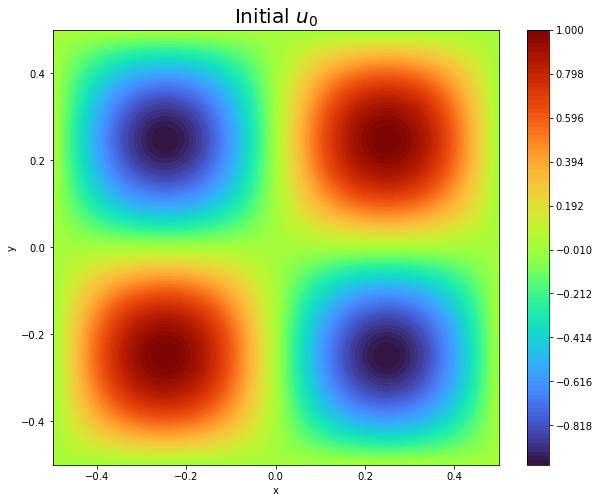

In [2]:
# L1 method
# set the fractional order in list to compute
# alpha_list = [0.1, 0.5,  0.7, 1]
alpha_list = [0.1, 0.3, 0.5,  0.7, 0.9, 1]
# boundary condition
BC = 'neumann'

# the width of interface
eps = 1e-4
# eps = 1

# define the saptial domain
# L = 10
L = 1
# determine the number of point in x or y direction
Nx = 2**7
h = L / Nx
x = np.linspace(h/2, L-h/2, Nx)
y = np.linspace(h/2, L-h/2, Nx)

# compute the mesh size
dt = 5*1e-3
iter_max = 200
# iter_max = 2000

t = np.arange(1,iter_max+1) * dt

# set the discrete laplacian
Lap = set_Laplacian2D(Nx, h, BC)

if BC == 'periodic':
#     x = x[:-1]
#     y = y[:-1]
    I = diags(np.ones((Nx)**2), shape=((Nx)**2, (Nx)**2))
elif BC == 'neumann':
    I = diags(np.ones((Nx)**2), shape=((Nx)**2, (Nx)**2))

    
    

# set the 2D mesh grid by x and y
X, Y = np.meshgrid(x, y)

# set the 2D mesh grid by x and y
x0 = np.linspace(-L/2, L/2, Nx+2)
y0 = np.linspace(-L/2, L/2, Nx+2)
X0, Y0 = np.meshgrid(x0, y0)


u0 = np.zeros((Nx+2, Nx+2))
# u0[1:-1, 1:-1] = np.sin(2*np.pi*(X))*np.cos(2*np.pi*Y)
u0[1:-1, 1:-1] = np.sin(2*np.pi*(X))*np.sin(2*np.pi*Y)
u0 = set_boundary(u0, BC)


# the dicitionary to storage the different fractional order results
data_dict = {}

info_dict = {
    'Nx': Nx,
    'dx': dt,
    'iteration': iter_max,
    'boundary': BC,
    'eps': eps
}

plt.figure(figsize=(10,8))
plt.contourf(X0,Y0, u0, cmap="turbo", levels=np.linspace(-1,1,100))
plt.colorbar()
plt.title(r'Initial $u_0$', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

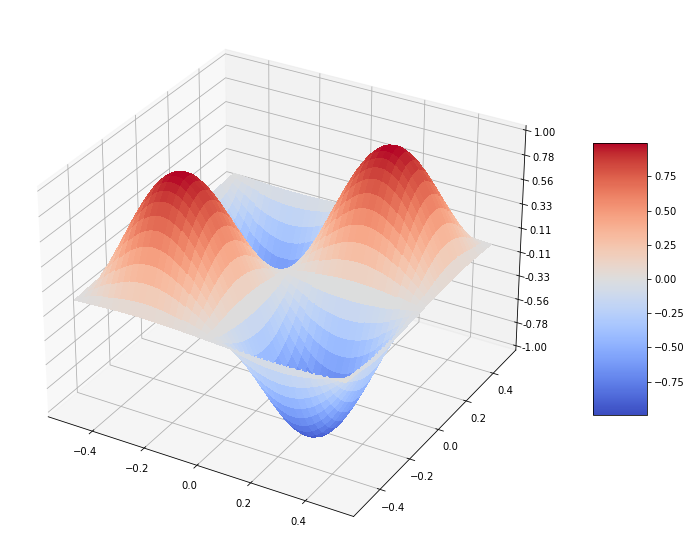

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(figsize=(15,10),subplot_kw={"projection": "3d"})
# Z = np.reshape(data_dict[0.5][-1], (Nx-1,Nx-1))
# Z = np.tanh((1-((X)**2+(Y)**2))/5)*0.2


# Plot the surface.
surf = ax.plot_surface(X0, Y0, u0, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [3]:
# alpha = 0.9


for alpha in alpha_list:
    print(f"alpha: {alpha}")
    # inital the history array
    u_historyArray = u0.copy().reshape(1, Nx+2, Nx+2)
    u = u0.copy()

    pbar = tqdm(total=iter_max)

    if alpha == 1:
        # solved by classical allen cahn
        H = (1/dt) * I - eps**2 * Lap

        for i in range(iter_max):
            u_interior = u[1:-1, 1:-1].copy().flatten()
            b = u_interior
            u[1:-1, 1:-1] = np.reshape(spsolve(H, b), (Nx, Nx))
            u = set_boundary(u, BC)
            u_historyArray = np.vstack([u_historyArray, u.reshape(1, Nx+2, Nx+2)])
            pbar.update(1)

    else:
        L1_coef = set_coef(iter_max, alpha, 'L1')/ dt**alpha / gamma(2-alpha)
        H = (L1_coef[0]) * I - eps**2 * Lap

        for i in range(iter_max):
            u_interior = u[1:-1, 1:-1].copy().flatten()
            if i == 0: # first iteration u_1
                b =  u_interior
                u[1:-1, 1:-1] = np.reshape(spsolve(H, b), (Nx, Nx))
                u = set_boundary(u, BC)
            else:
                u_nonlocalDiff = np.flipud(np.diff(u_historyArray[:, 1:-1, 1:-1], axis=0))
                u_nonlocal = np.tensordot(L1_coef[1:i+1], u_nonlocalDiff, axes=1)

                b = u_interior - u_nonlocal.flatten()
                u[1:-1, 1:-1] = np.reshape(spsolve(H, b), (Nx, Nx))
                u = set_boundary(u, BC)


            u_historyArray = np.vstack([u_historyArray, u.reshape(1, Nx+2, Nx+2)])
            pbar.update(1)


    data_dict[alpha] = u_historyArray

    pbar.close()

alpha: 0.1


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:15<00:00, 12.78it/s]


alpha: 0.3


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 12.40it/s]


alpha: 0.5


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:15<00:00, 12.57it/s]


alpha: 0.7


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:15<00:00, 12.71it/s]


alpha: 0.9


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 12.40it/s]


alpha: 1


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 13.93it/s]


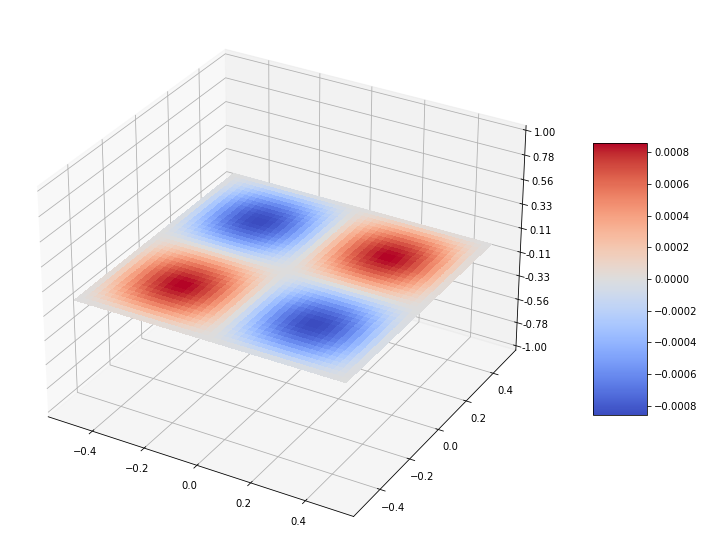

In [19]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(figsize=(15,10),subplot_kw={"projection": "3d"})
# Z = np.reshape(data_dict[0.5][-1], (Nx-1,Nx-1))
# Z = np.tanh((1-((X)**2+(Y)**2))/5)*0.2


# Plot the surface.
surf = ax.plot_surface(X0, Y0, data_dict[0.9][-1], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [37]:
# DifferenceMass = []
hh = L / Nx
sum_list = [np.sum(_[1:-1,1:-1]) for _ in np.diff(data_dict[alpha], axis=0)]

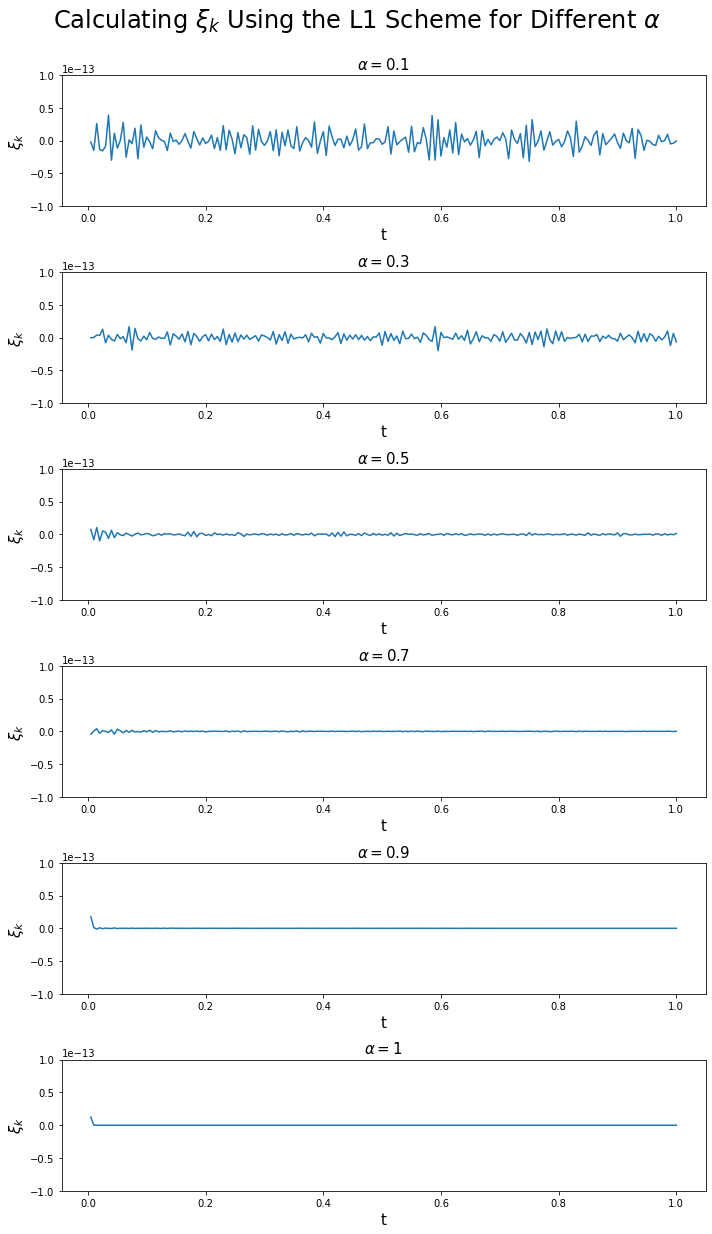

In [4]:
fig, ax = plt.subplots(len(alpha_list), 1, figsize=(10, 18))
i = 0
for alpha in alpha_list:
    sum_list = [np.sum(_[1:-1,1:-1]) for _ in np.diff(data_dict[alpha], axis=0)]
    ax[i].plot(t, sum_list, '-')
    ax[i].set_title(r'$\alpha=$'+f'{alpha}', fontsize=15)
    ax[i].set_xlabel('t', fontsize=15)
    ax[i].set_ylabel(r'$\xi_k$', fontsize=15)
    ax[i].set_ylim([-1e-13, 1e-13])
    i += 1
fig.suptitle(r'Calculating $\xi_k$ Using the L1 Scheme for Different $\alpha$', fontsize=24)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

In [5]:
# alpha = 0.9


for alpha in alpha_list:
    print(f"alpha: {alpha}")
    # inital the history array
    u_historyArray = u0.copy().reshape(1, Nx+2, Nx+2)
    u = u0.copy()

    pbar = tqdm(total=iter_max)

    if alpha == 1:
        # solved by classical allen cahn
        H = (1/dt) * I - eps**2 * Lap

        for i in range(iter_max):
            u_interior = u[1:-1, 1:-1].copy().flatten()
            b = u_interior
            u[1:-1, 1:-1] = np.reshape(spsolve(H, b), (Nx, Nx))
            u = set_boundary(u, BC)
            u_historyArray = np.vstack([u_historyArray, u.reshape(1, Nx+2, Nx+2)])
            pbar.update(1)

    else:
        GL_coef = set_coef(iter_max, alpha, 'GL') / dt**alpha
        H = (GL_coef[0]+2) * I - eps**2 * Lap

        for i in range(iter_max):
            u_interior = u[1:-1, 1:-1].copy().flatten()
            if i == 0: # first iteration u_1
                b =  u_interior
                u[1:-1, 1:-1] = np.reshape(spsolve(H, b), (Nx, Nx))
                u = set_boundary(u, BC)
            else:
                u_nonlocalDiff = np.flipud(u_historyArray[1:,1:-1,1:-1]-u0[1:-1, 1:-1])
                u_nonlocal = np.tensordot(GL_coef[1:i+1], u_nonlocalDiff, axes=1)

                b = u_interior + GL_coef[0]*u0[1:-1,1:-1].flatten() -  u_nonlocal.flatten()
                u[1:-1, 1:-1] = np.reshape(spsolve(H, b), (Nx, Nx))
                u = set_boundary(u, BC)


            u_historyArray = np.vstack([u_historyArray, u.reshape(1, Nx+2, Nx+2)])
            pbar.update(1)


    data_dict[alpha] = u_historyArray

    pbar.close()

alpha: 0.1


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:15<00:00, 12.84it/s]


alpha: 0.3


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:15<00:00, 12.52it/s]


alpha: 0.5


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 12.36it/s]


alpha: 0.7


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 12.07it/s]


alpha: 0.9


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 12.15it/s]


alpha: 1


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 13.76it/s]


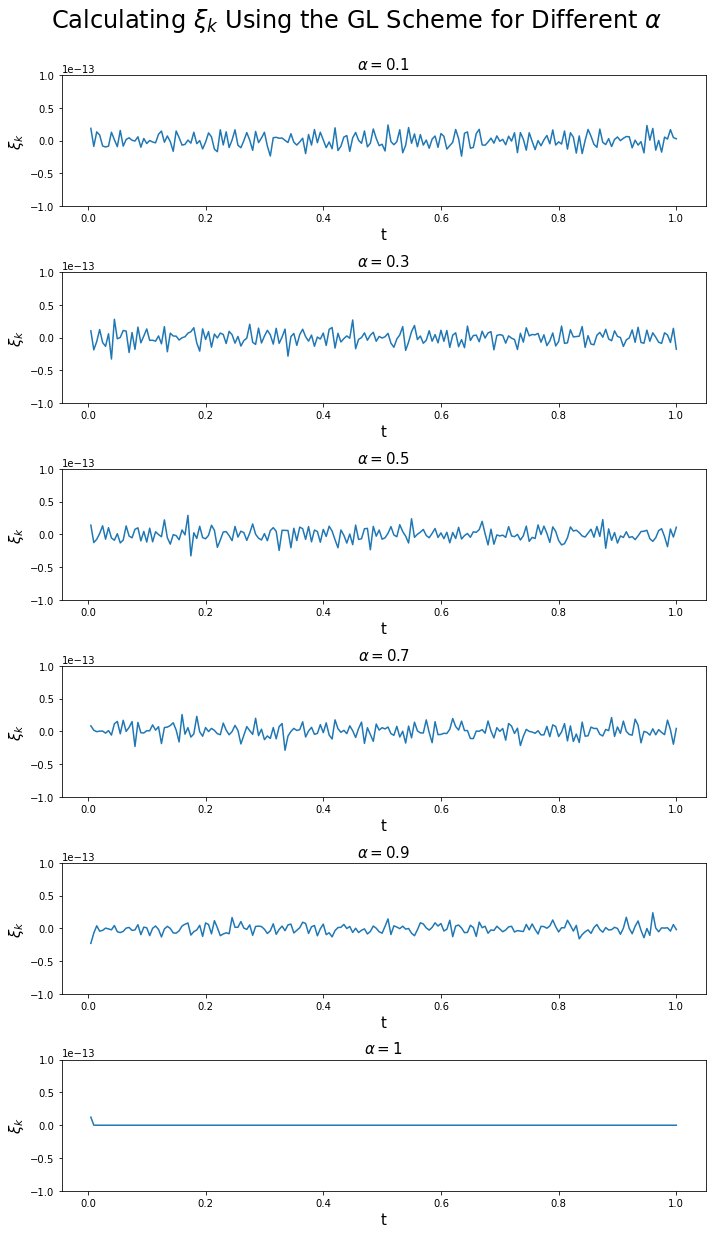

In [7]:
fig, ax = plt.subplots(len(alpha_list), 1, figsize=(10, 18))
i = 0
for alpha in alpha_list:
    sum_list = [np.sum(_[1:-1,1:-1]) for _ in np.diff(data_dict[alpha], axis=0)]
    ax[i].plot(t, sum_list, '-')
    ax[i].set_title(r'$\alpha=$'+f'{alpha}', fontsize=15)
    ax[i].set_xlabel('t', fontsize=15)
    ax[i].set_ylabel(r'$\xi_k$', fontsize=15)
    ax[i].set_ylim([-1e-13, 1e-13])
    i += 1
fig.suptitle(r'Calculating $\xi_k$ Using the GL Scheme for Different $\alpha$', fontsize=24)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()